# Model engineering 001: MultiLinearRegression

In this part of the project to predict the photovoltaic production of solar cells on a roof we are considering a simple regression model - MultiLinearRegression. 



## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

import eli5
sns.set()

Using TensorFlow backend.


## Import dataset

### DarkSky - Weather data

In [2]:
df_weather = pd.read_csv('../02.Prepared_data/DarkSky/data_after_missing_value_treatment.csv', parse_dates=['time', 'sunriseTime', 'sunsetTime'])
df_weather.head()

,time,apparentTemperatureHigh,apparentTemperatureLow,cloudCover,precipProbability,precipType,sunriseTime,sunsetTime,temperatureHigh,uvIndex,precipIntensityMax_cm,sun_uptime
0,2017-10-01,15.92,9.71,NaN,0.76,rain,2017-10-01 07:29:00,2017-10-01 19:09:00,16.20,4.0,0.498348,11.666667
1,2017-10-02,17.15,12.70,0.81,0.81,rain,2017-10-02 07:30:00,2017-10-02 19:07:00,17.43,3.0,0.548386,11.616667
2,2017-10-03,16.14,5.25,0.76,0.99,rain,2017-10-03 07:32:00,2017-10-03 19:05:00,16.42,4.0,23.600410,11.550000
3,2017-10-04,15.47,4.75,NaN,0.62,rain,2017-10-04 07:33:00,2017-10-04 19:03:00,15.75,0.0,0.403606,11.500000
4,2017-10-05,19.81,5.68,NaN,0.99,rain,2017-10-05 07:34:00,2017-10-05 19:01:00,20.09,1.0,8.199120,11.450000


In [3]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 12 columns):
time                       929 non-null datetime64[ns]
apparentTemperatureHigh    929 non-null float64
apparentTemperatureLow     847 non-null float64
cloudCover                 744 non-null float64
precipProbability          837 non-null float64
precipType                 839 non-null object
sunriseTime                929 non-null datetime64[ns]
sunsetTime                 929 non-null datetime64[ns]
temperatureHigh            929 non-null float64
uvIndex                    895 non-null float64
precipIntensityMax_cm      839 non-null float64
sun_uptime                 922 non-null float64
dtypes: datetime64[ns](3), float64(8), object(1)
memory usage: 87.2+ KB


### Solar output data

In [4]:
df_prod = pd.read_csv('../02.Prepared_data/photovoltaic/integrated_daily.csv', parse_dates=['day'])
df_prod.head()

,day,energy,season
0,2017-10-12,2.907333,fall
1,2017-10-13,29.549000,fall
2,2017-10-14,28.653833,fall
3,2017-10-15,28.409750,fall
4,2017-10-16,27.371084,fall


In [5]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 3 columns):
day       624 non-null datetime64[ns]
energy    624 non-null float64
season    624 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 14.8+ KB


## Merge datasets

In [6]:
df = pd.merge(df_prod, df_weather, left_on='day', right_on='time')
df = df.set_index('day')

In [7]:
# what missing values there are
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing,
                                'absolute_missing': df.isnull().sum()})
missing_value_df

,column_name,percent_missing,absolute_missing
energy,energy,0.000000,0
season,season,0.000000,0
time,time,0.000000,0
apparentTemperatureHigh,apparentTemperatureHigh,0.000000,0
apparentTemperatureLow,apparentTemperatureLow,13.141026,82
cloudCover,cloudCover,29.006410,181
precipProbability,precipProbability,14.743590,92
precipType,precipType,14.423077,90
sunriseTime,sunriseTime,0.000000,0
sunsetTime,sunsetTime,0.000000,0


In [8]:
df_prod.shape, df.shape

((624, 3), (624, 14))

Looks good, we have the two datasets merged. Let us now consider which features we are going to use for our prediction.

## Feature selection


This step is non-trivial, but we already know from the correlation matrix that there are some highly correlated values among the temperature columns.

In [10]:
%matplotlib widget
# %matplotlib inline

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df_weather.corr(), ax=ax, annot=True, cmap='viridis', fmt="0.2f");
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Since the `apparentTemperatureHigh` column has no missing values, we will use this column as the temperature information and drop the others. Also we can drop `time`, `sunriseTime`, and `sunSetTime` since they are not relevant further (we know the difference between sunset and rise from the `sun_uptime` column).

In [11]:
df_cleaned = df.drop(columns=['time', 'apparentTemperatureLow', 'temperatureHigh', 'sunriseTime', 'sunsetTime'])
df_cleaned.head()

,energy,season,apparentTemperatureHigh,cloudCover,precipProbability,precipType,uvIndex,precipIntensityMax_cm,sun_uptime
day,,,,,,,,,
2017-10-12,2.907333,fall,18.74,0.68,0.00,none,3.0,0.000000,11.050000
2017-10-13,29.549000,fall,21.26,NaN,0.70,rain,0.0,0.330708,10.983333
2017-10-14,28.653833,fall,21.30,NaN,0.63,rain,0.0,0.305562,10.933333
2017-10-15,28.409750,fall,25.41,NaN,0.62,rain,0.0,0.406146,10.866667
2017-10-16,27.371084,fall,25.55,NaN,0.00,none,0.0,0.000000,10.816667


In [13]:
%matplotlib widget
# %matplotlib inline

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df_cleaned.corr(), ax=ax, annot=True, cmap='viridis', fmt="0.2f");
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


We can see now that the target column, `energy` is highly positively correlated with the temperature and uptime and moderately negatively correlated with the `cloudCover` column which is not very surprising and agrees with our intuition - when the temperature and sun hours are high, the energy produced during one day will be high and if there are a lot of clouds, there will be less energy produced.

## Missing values

We already know that there are a bunch of missing values in 2018 and they are clumped, so there is nothing to be done about it. We will drop these columns. 

We will also drop the `cloudCover` column because it has the most missing values and is correlated with the probability for precipitation for which we have more datapoints. That way we do not loose 30% of the data, but only around 15%.

In [14]:
df_cleaned = df_cleaned.drop(columns=['cloudCover'])
size_before = df_cleaned.shape[0]
df_cleaned = df_cleaned.dropna()
size_after = df_cleaned.dropna().shape[0]
print(f"Dropped {size_before-size_after} ({100 * (size_before-size_after)/size_before:.2f}%) entries because of missing values. New size is {size_after} entries.")

Dropped 93 (14.90%) entries because of missing values. New size is 531 entries.


### Export this dataset

Exporting this dataset makes sense because we can save the analysis steps for other models that we consider and make sure that we use the same baseline for the other models.

In [15]:
df_cleaned.to_csv('../02.Prepared_data/dataset.Model_eng.001.csv', index=False)

## Select features

In [16]:
# X = df_cleaned.iloc[:, 1:].values
X = df_cleaned.iloc[:, 1:]
X = X.reset_index(drop=True)
# y = df_cleaned.iloc[:, 0].values
y = df_cleaned.iloc[:, 0]
y = y.reset_index(drop=True)

## Pipeline

Let's make our pipeline for the preprocessing here. That allows later some easier changes.

In [17]:
X.head()

,season,apparentTemperatureHigh,precipProbability,precipType,uvIndex,precipIntensityMax_cm,sun_uptime
0,fall,18.74,0.00,none,3.0,0.000000,11.050000
1,fall,21.26,0.70,rain,0.0,0.330708,10.983333
2,fall,21.30,0.63,rain,0.0,0.305562,10.933333
3,fall,25.41,0.62,rain,0.0,0.406146,10.866667
4,fall,25.55,0.00,none,0.0,0.000000,10.816667


### Numeric features: StandardScaler

Standardize features by removing the mean and scaling to unit variance

In [18]:
numeric_features = ['apparentTemperatureHigh', 'precipProbability', 'uvIndex', 'precipIntensityMax_cm', 'sun_uptime']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

### Categorical features: OneHotEncoder

Standardize features by removing the mean and scaling to unit variance

In [19]:
categorical_features = ['season', 'precipType']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### Model

In [20]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Fit

In [21]:
clf.fit(X_train, y_train);

### Score (Full model, M0)


In [22]:
def adjR2(R2, n, p):
    """
    Returns the adjusted R2 score using R2 score, n, and p.
    n: size of dataset
    p: number of predictors
    """
    return 1-(1-R2)*(n-1)/(n-p-1)

In [23]:
y_test_predict = clf.predict(X_test)
y_train_predict = clf.predict(X_train)

M0_R2 = r2_score(y_test, y_test_predict)
M0_R2_train = r2_score(y_train, y_train_predict)

n = X_train.shape[0]
p = 1
M0_adj_R2 = adjR2(M0_R2, n, p)
M0_adj_R2_train = adjR2(M0_R2_train, n, p)

print(f"Train dataset -- R2 score: {M0_R2_train:.2f}, adjusted R2: {M0_adj_R2_train:.2f}.")
print(f"Test dataset -- R2 score: {M0_R2:.2f}, adjusted R2: {M0_adj_R2:.2f}.")

Train dataset -- R2 score: 0.77, adjusted R2: 0.77.
Test dataset -- R2 score: 0.72, adjusted R2: 0.72.


### Feature importance


In [24]:
# get importance
importance = clf['classifier'].coef_

# get feature names
onehot_columns = list(clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)



# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
fig, ax = plt.subplots(figsize=(9,5))
plt.bar([x for x in range(len(importance))], importance, align='center')
plt.xticks(np.arange(0, len(importance)), numeric_features_list, rotation=90)
plt.show()

Feature: 0, Score: 5.94872
Feature: 1, Score: -3.94178
Feature: 2, Score: 0.90374
Feature: 3, Score: -1.73715
Feature: 4, Score: 5.18637
Feature: 5, Score: -2.65664
Feature: 6, Score: 3.86144
Feature: 7, Score: -3.12073
Feature: 8, Score: 1.91593
Feature: 9, Score: -0.37593
Feature: 10, Score: -1.28071
Feature: 11, Score: 1.65664


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
eli5.explain_weights(clf.named_steps['classifier'], top=20, feature_names=numeric_features_list)

Weight?,Feature
+20.132,<BIAS>
+5.949,apparentTemperatureHigh
+5.186,sun_uptime
+3.861,season_spring
+1.916,season_winter
+1.657,precipType_snow
+0.904,uvIndex
-0.376,precipType_none
-1.281,precipType_rain
-1.737,precipIntensityMax_cm


We see that the temperature and sun uptime have high linear coefficients. For model selection, we will now use forward stepwise selection.

## Backward elimination

Let's use the p-values to select parameters to stay in the model. For that we will use backward elimination.

1. Select significance level to stay in the model. We use $\alpha=0.05$.

2. Fit full model with all predictors

3. Consider predictor with highest p-value. If that p-value $> \alpha$, go to step 4, otherwise end.

4. Remove the predictor with the largest p-value.

5. Fit model without this variable, back to step 3.

### Get the full model 

In [26]:
pipe_preprocess = clf.named_steps['preprocessor']
# transform the feature data using the training data
X_train_transformed = pipe_preprocess.fit_transform(X_train)
X_test_transformed = pipe_preprocess.fit_transform(X_test)
# add back the column headers
# get feature names
onehot_columns = list(clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=numeric_features_list, dtype=np.float)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=numeric_features_list, dtype=np.float)
X_train_transformed_full = X_train_transformed.copy()
X_train_transformed.head()

,apparentTemperatureHigh,precipProbability,uvIndex,precipIntensityMax_cm,sun_uptime,season_fall,season_spring,season_summer,season_winter,precipType_none,precipType_rain,precipType_snow
0,0.953787,-0.860363,-0.208535,-0.471901,-0.132779,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.874835,-1.013745,0.291007,-0.558235,0.315595,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.107047,-1.090436,0.291007,-0.577376,-0.289030,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.404278,-1.167127,-1.207619,-0.580430,0.974569,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.490525,1.133605,1.789633,-0.270419,1.232724,0.0,1.0,0.0,0.0,0.0,1.0,0.0


This is the full model, let's now implement the backward elimination procedure.

In [27]:
import statsmodels.api as sm

    
alpha = 0.05 # significance level
pvals_max = 10

while pvals_max >= alpha:
    #Adding constant column of ones, mandatory for sm.OLS model
    X_train_1 = sm.add_constant(X_train_transformed)
    #Fitting sm.OLS model
    model = sm.OLS(y_train.values, X_train_1).fit()
    pvals = model.pvalues.sort_values()
    # largest pval is at the last position of the series
    pvals_max = pvals.iloc[-1]
    col_to_drop = pvals.index[-1]
    X_train_transformed = X_train_transformed.drop(columns=[col_to_drop])

pvals

/Users/hkromer/anaconda3/envs/solarAnalytics/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const                      7.208224e-68
apparentTemperatureHigh    1.173004e-19
sun_uptime                 1.806670e-17
precipProbability          5.241167e-14
precipType_snow            7.337528e-10
precipType_rain            2.881559e-09
season_spring              6.159340e-09
season_winter              3.840635e-05
precipIntensityMax_cm      2.543960e-04
precipType_none            2.696352e-04
dtype: float64

In [28]:
features = pvals.index.tolist()
features = [f for f in features if f is not 'const']
features

['apparentTemperatureHigh',
 'sun_uptime',
 'precipProbability',
 'precipType_snow',
 'precipType_rain',
 'season_spring',
 'season_winter',
 'precipIntensityMax_cm',
 'precipType_none']

Using backward elimination we found the features to be used in the model to be:

`apparentTemperatureHigh`, <br>
`sun_uptime`,<br>
`precipProbability`,<br>
`precipType_snow`,<br>
`precipType_rain`,<br>
`season_spring`,<br>
`season_winter`,<br>
`precipIntensityMax_cm`,<br>
`precipType_none`

Let's run the regression model with these features.

In [29]:
# drop the features we did not want to consider
cols_to_drop = X_train_transformed_full.columns
cols_to_drop = [c for c in cols_to_drop if c not in features]
X_train_transformed_full = X_train_transformed_full.drop(columns=cols_to_drop)
X_test_transformed = X_test_transformed.drop(columns=cols_to_drop)

In [30]:
# run model
pipe_lm = clf.named_steps['classifier']
pipe_lm.fit(X_train_transformed_full, y_train)

y_test_predict = pipe_lm.predict(X_test_transformed)
y_train_predict = pipe_lm.predict(X_train_transformed_full)

M1_R2 = r2_score(y_test, y_test_predict)
M1_R2_train = r2_score(y_train, y_train_predict)

n = X_train.shape[0]
p = 1
M1_adj_R2 = adjR2(M1_R2, n, p)
M1_adj_R2_train = adjR2(M1_R2_train, n, p)
print("Backward eliminated model:")
print(f"Train dataset -- R2 score: {M1_R2_train:.2f}, adjusted R2: {M1_adj_R2_train:.2f}.")
print(f"Test dataset -- R2 score: {M1_R2:.2f}, adjusted R2: {M1_adj_R2:.2f}.")

Backward eliminated model:
Train dataset -- R2 score: 0.77, adjusted R2: 0.76.
Test dataset -- R2 score: 0.69, adjusted R2: 0.69.


In [31]:
print("Full model:")
print(f"Train dataset -- R2 score: {M0_R2_train:.2f}, adjusted R2: {M0_adj_R2_train:.2f}.")
print(f"Test dataset -- R2 score: {M0_R2:.2f}, adjusted R2: {M0_adj_R2:.2f}.")

Full model:
Train dataset -- R2 score: 0.77, adjusted R2: 0.77.
Test dataset -- R2 score: 0.72, adjusted R2: 0.72.


We see that from the R2 score, our eliminated model performed worse compared to the full model.

## Forward stepwise selection

The approach for forward stepwise selection is the following:

1. Start with the null model, $M_0$ that contains no predictors.


2. For $k = 1, ... p-1$:

    a. Consider all $p-k$ models that augment the predictors in $M_k$ with one additional predictor
    
    b. Choose the best among these $p-k$ models, call it $M_{k+1}$. Best is defined as having the smallest RSS or highest R$^2$
    
    
3. Select a single best model from among $M_0, ..., M_p$ using crossvalidated prediction error, $C_p$ (AIC), BIC, or adjusted R$^2$.

In [56]:
adjR2s = []
CPs = []
BICs = []
features_good = []

### Null model 

In [57]:
#Fitting sm.OLS model
X_train_tmp = sm.add_constant(X_train)['const']
model = sm.OLS(y_train.values, X_train_tmp).fit()

adjR2s.append(model.rsquared_adj)
CPs.append(model.aic)
BICs.append(model.bic)

/Users/hkromer/anaconda3/envs/solarAnalytics/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Forward stepwise selection


To implement the forward stepwise selection, we first preprocess all the features.

In [58]:
pipe_preprocess = clf.named_steps['preprocessor']
# transform the feature data using the training data
X_train_tf = pipe_preprocess.fit_transform(X_train)
X_test_tf = pipe_preprocess.fit_transform(X_test)
# add back the column headers
# get feature names
onehot_columns = list(clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)
X_train_tf = pd.DataFrame(X_train_tf, columns=numeric_features_list, dtype=np.float)
X_test_tf = pd.DataFrame(X_test_tf, columns=numeric_features_list, dtype=np.float)

# features that can be added to the model
features = X_train_tf.columns

while len(features) > 0:
    r2 = pd.Series() # rsquared values in this iteration
    for f in features:
        features_select = features_good.copy()
        features_select.append(f)
        # features to select from the dataframe
        X_tmp = sm.add_constant(X_train_tf[features_select])
        model = sm.OLS(y_train.values, X_tmp).fit()
        # check if that r2 is higher
        r2[f] = model.rsquared

    # feature with maximum r2 gets added to the selected feature list
    f = r2.sort_values().index[-1]
    features_good.append(f)
    # remove the feature from the features for the next iteration
    features = features.drop(f)
    
    # compute metrics from these models
    X_tmp = sm.add_constant(X_train_tf[features_good])
    model = sm.OLS(y_train.values, X_tmp).fit()
    adjR2s.append(model.rsquared_adj)
    CPs.append(model.aic)
    BICs.append(model.bic)
    
adjR2s = np.asarray(adjR2s)
CPs = np.asarray(CPs)
BICs = np.asarray(BICs)


/Users/hkromer/anaconda3/envs/solarAnalytics/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [72]:
%matplotlib widget

fig, axs = plt.subplots(2, 2, sharex=True)

axs[0][0].plot(np.arange(len(adjR2s)), adjR2s, marker='o', color='blue', alpha=0.4)
axs[0][0].set_xlabel('Model')
axs[0][0].set_ylabel('adjusted R2 Score')
adjR2_best = np.argmax(adjR2s)
axs[0][0].scatter([adjR2_best], [np.max(adjR2s)], marker='+', s=100, color='black')

axs[0][1].plot(np.arange(len(CPs)), CPs, marker='o', color='red', alpha=0.4)
axs[0][1].set_xlabel('Model')
axs[0][1].set_ylabel('AIC Score')
CPs_best = np.argmin(CPs)
axs[0][1].scatter([CPs_best], [np.min(CPs)], marker='+', s=100, color='black')


axs[1][0].plot(np.arange(len(BICs)), BICs, marker='o', color='orange', alpha=0.4)
axs[1][0].set_xlabel('Model')
axs[1][0].set_ylabel('BIC Score')
BIC_best = np.argmin(BICs)
axs[1][0].scatter([idx_min], [np.min(BICs)], marker='+', s=100, color='black')

plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [74]:
adjR2_best, CPs_best, BIC_best

(8, 8, 6)

On the training data set, the model with 9 or 7 features (index in the list starts at 0) performs best, let's see how that performs on the test dataset.

In [75]:
features_good

['sun_uptime',
 'precipProbability',
 'apparentTemperatureHigh',
 'season_spring',
 'season_winter',
 'precipIntensityMax_cm',
 'precipType_snow',
 'uvIndex',
 'precipType_rain',
 'season_summer',
 'precipType_none',
 'season_fall']

### Pandas dummies approach

Test dataset -- R2 score: 0.72, adjusted R2: 0.72.
Feature: 0, Score: 5.94872
Feature: 1, Score: -3.94178
Feature: 2, Score: 0.90374
Feature: 3, Score: -1.73715
Feature: 4, Score: 5.18637
Feature: 5, Score: -1.48863
Feature: 6, Score: 1.45855
Feature: 7, Score: -1.06796
Feature: 8, Score: 0.54459
Feature: 9, Score: -0.03201
Feature: 10, Score: -0.40908
Feature: 11, Score: 0.58222


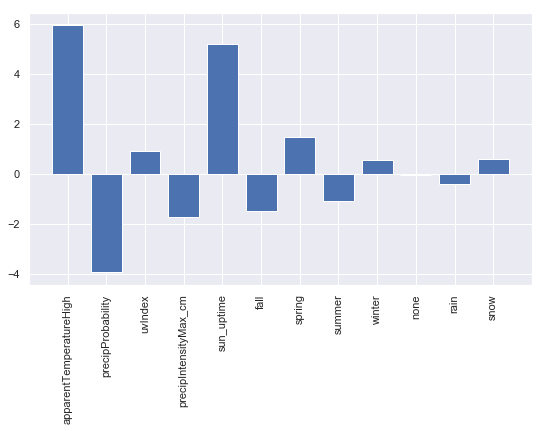

In [23]:
# X = df_cleaned.iloc[:, 1:].values
X = df_cleaned.iloc[:, 1:]
X = X.reset_index(drop=True)
# y = df_cleaned.iloc[:, 0].values
y = df_cleaned.iloc[:, 0]
y = y.reset_index(drop=True)

X_season = pd.get_dummies(X['season'])
X = X.drop(columns=['season'])
X_precip = pd.get_dummies(X['precipType'])
X = X.drop(columns=['precipType'])

X = pd.merge(X, X_season, left_on=X.index, right_on=X_season.index)
X = X.drop(columns=['key_0'])

X = pd.merge(X, X_precip, left_on=X.index, right_on=X_precip.index)
X = X.drop(columns=['key_0'])

numeric_features = X.columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
        ])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train);

y_test_predict = clf.predict(X_test)
R2_fm = r2_score(y_test, y_test_predict)

n = X_train.shape[0]
p = 1
adj_R2_fm = 1-(1-R2_fm)*(n-1)/(n-p-1)
print(f"Test dataset -- R2 score: {R2_fm:.2f}, adjusted R2: {adj_R2_fm:.2f}.")


# get importance
importance_dummies = clf['classifier'].coef_

# get feature names
numeric_features_list_dummies = X.columns



# summarize feature importance
for i,v in enumerate(importance_dummies):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
fig, ax = plt.subplots(figsize=(9,5))
p = plt.bar([x for x in range(len(importance_dummies))], importance_dummies, align='center')
plt.xticks(np.arange(0, len(importance_dummies)), numeric_features_list_dummies, rotation=90)
plt.show()

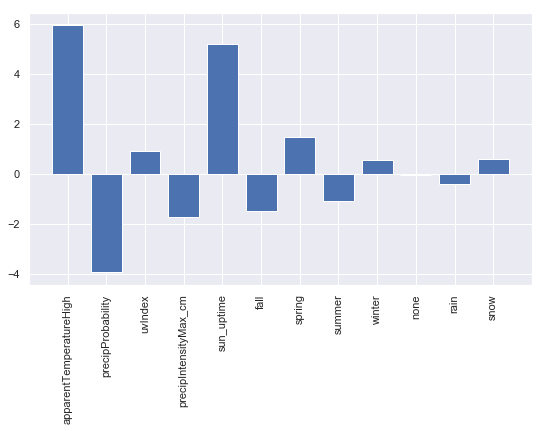

In [24]:
# plot feature importance
fig, ax = plt.subplots(figsize=(9,5))
p = plt.bar([x for x in range(len(importance_dummies))], importance_dummies, align='center')
plt.xticks(np.arange(0, len(importance_dummies)), numeric_features_list_dummies, rotation=90)
plt.show()

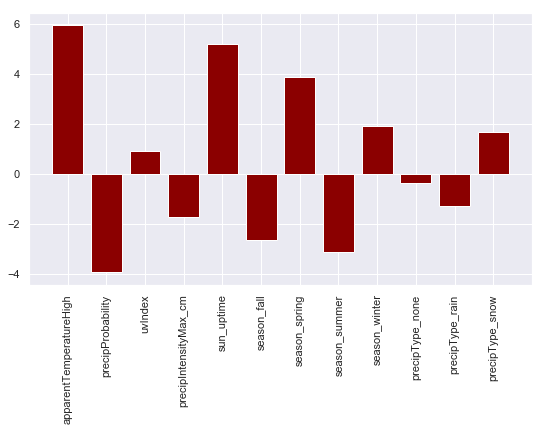

In [25]:
# plot feature importance
fig, ax = plt.subplots(figsize=(9,5))
plt.bar([x for x in range(len(importance))], importance, align='center', color='darkred')
plt.xticks(np.arange(0, len(importance)), numeric_features_list, rotation=90)
plt.show()